In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# !!! uncomment for first run

import os

import numpy as np  # linear algebra
#!pip install librosa
import torch

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import string
chars = string.ascii_lowercase
chars = ['', ' '] + list(chars) 
print(chars)
print(len(chars))

['', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
28


In [3]:
vocab = {j: i for i, j in enumerate(chars)}


#inv_vocab = {i : j for i, j in enumerate(chars)}\
def one_hot(data):
    out = np.zeros((len(data), len(chars)))
    for i, j in enumerate(data):
        out[i, vocab[j]] = 1
    return out


def indexed(data):
    return np.asarray([vocab[i] for i in data if i in chars])


indexed("test")

array([21,  6, 20, 21])

In [6]:
from datasets import load_dataset
import librosa as li

def mapper(line):
    return {"text": indexed(line["text"].lower()), "audio":li.resample(line["audio"]["array"], orig_sr=16000, target_sr=11025)}

def fft(line):
    resampled = torch.tensor(line["audio"]).cuda()
    fft = torch.nn.functional.normalize(torch.log(torch.stft(resampled, n_fft=511, hop_length=255, window=torch.hann_window(511).cuda(), return_complex=True)[..., :-1].abs() + 1).squeeze(-1), dim=0)
    return {"audio" : fft.cpu().detach()}
## !! WARNING !!
## THIS DOWNLOADS 60GB OF DATA
ds = load_dataset("edinburghcstr/ami", "ihm")
ds = ds.map(mapper, num_proc=32)
ds = ds.filter(lambda x: len(x['audio']) > 512, num_proc=32)
ds = ds.map(fft, num_proc=16)
#split = ds.train_test_split(test_size=0.02)
train = ds['train']
test = ds['test']

Map (num_proc=16):   0%|          | 0/108461 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/13094 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/12641 [00:00<?, ? examples/s]

In [4]:
ds.cleanup_cache_files()

NameError: name 'ds' is not defined

In [7]:
from torch.utils.data import Dataset


class SongDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.sr = 11025

    def line_sample(self, line):
        if len(line) < 2:
            line = np.pad(line, (3, 0), 'constant', constant_values=0)
        window = np.lib.stride_tricks.sliding_window_view(line, 2, axis=0)
        #window = np.pad(window, [(0,0), (0, max(10 - window.shape[0], 0))])
        return window[np.random.randint(0, window.shape[0], size=3),:]

    def get_negative(self):
        negatives = self.data.select(np.random.randint(0, self.data.shape[0] - 1,size=(10,)))
        negatives =  np.concatenate(negatives["text"], axis=0)
        window = np.lib.stride_tricks.sliding_window_view(negatives, 2, axis=0)
        return window[np.random.randint(0, window.shape[0], size=3),:]


    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        line = self.data[index] 
        fft = torch.tensor(line["audio"])
        padding = 216 - fft.size(1)
        fft = nn.functional.pad(fft, (0,padding), value=0)
        mask = torch.ones(fft.size(1),)
        mask[-padding+216:] = 0
        tokens_pos = torch.Tensor(self.line_sample(line["text"])).int()
        tokens_neg = torch.Tensor(self.get_negative()).int()
        return tokens_pos, tokens_neg, fft.detach(), mask

In [39]:
from torch.nn.utils.parametrizations import weight_norm
from torch import nn


class RCBComp(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = nn.GroupNorm(8, 64)
        self.activation = nn.ReLU()
        self.conv = nn.Conv2d(64, 64, 3, padding=1)

    def forward(self, x):
        x = self.norm(x)
        x = self.activation(x)
        x = self.conv(x)
        return x


class RCB(nn.Module):
    def __init__(self):
        super().__init__()
        self.comp1 = RCBComp()
        self.comp2 = RCBComp()

    def forward(self, x):
        o = self.comp1(x)
        o = self.comp2(o)
        return o + x


class AudioEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.projector = nn.Conv2d(1, 64, 1)
        self.blocks = nn.Sequential(*[RCB() for _ in range(10)])
        self.reduce = nn.Conv2d(64, 64, (256, 1))
        #self.norm = nn.LayerNorm([256, 216], elementwise_affine=False, bias=False)

    def forward(self, x):
        #print(x.shape)
        projected = self.projector(x.unsqueeze(1))
        #print(projected.shape)
        processed = self.blocks(projected)
        #print(processed.shape)
        reduced = self.reduce(processed)
        #print(reduced.shape)
        return reduced.squeeze(2).permute(0, 2, 1)


(3, 2)
55125
55125


torch.Size([1, 256, 216])

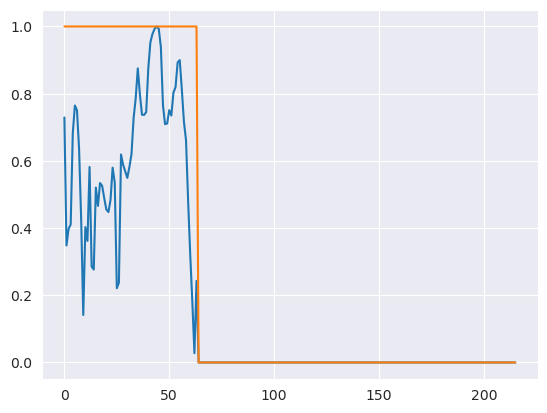

In [9]:
import matplotlib.pyplot as plt

ds = SongDataset(train)
print(ds.get_negative().shape)
ae = AudioEncoder()
print(5*ds.sr)
te = ds[55][2].unsqueeze(0)
print(5*ds.sr)
plt.plot((te/te.max(dim=-1, keepdim=True).values).squeeze(0)[9])
plt.plot(ds[55][3])
te.shape

In [10]:



class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddings = nn.Embedding(28, 64)  #nn.Linear(47, 64, bias=False)
        self.linear = nn.Linear(128, 64)
        self.act = nn.ReLU()
        self.proj = nn.Linear(64, 128)

    def forward(self, x):
        emb = self.embeddings(x)
        processed = self.linear(torch.flatten(emb, start_dim=2))
        processed = self.act(processed)
        return self.proj(processed).reshape(x.size(0), -1, 64) #+ emb.reshape(x.size(0), -1, 64) 

In [20]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.audio = AudioEncoder()
        self.text = TextEncoder()

    def text_embedding(self, x):
        text_embeddings = self.text(x).reshape(x.size(0) * x.size(1), x.size(2), -1)
        return nn.functional.normalize(text_embeddings, dim=-1), torch.linalg.norm(text_embeddings, dim=-1).mean() # nn.functional.normalize
    
    def inference(self, a, t):
        t = self.text_embedding(t)
        a = self.audio(a)
        a = nn.functional.normalize(a, dim=-1)
        a = a.repeat([t.size(1), 1, 1])
        return torch.bmm(t, a.permute(0, 2, 1)).reshape(t.size(0), t.size(1), t.size(2), -1), l
    
    def forward(self, a, tp, tn):
        #print(text_embeddings.shape)
          #text_embeddings / torch.linalg.norm(text_embeddings, dim=-1, keepdim=True)
        tpe, ntp = self.text_embedding(tp)
        tne, nte = self.text_embedding(tn)
        audio_embeddings = self.audio(a)
        na = torch.linalg.norm(audio_embeddings, dim=-1).mean()
        #print(audio_embeddings.shape)
        audio_embeddings_norm = nn.functional.normalize(audio_embeddings, dim=-1)  #audio_embeddings / torch.linalg.norm(audio_embeddings, dim=-1, keepdim=True)
        #audio_embeddings_norm = audio_embeddings_norm.repeat([t.size(1), 1, 1])
        #print(audio_embeddings_norm.shape)
        similarity_pos = torch.bmm(tpe, audio_embeddings_norm.repeat([tp.size(1), 1, 1]).permute(0, 2, 1)).reshape(tp.size(0), tp.size(1), tp.size(2), -1)
        similarity_neg = torch.bmm(tne, audio_embeddings_norm.repeat([tn.size(1), 1, 1]).permute(0, 2, 1)).reshape(tn.size(0), tn.size(1), tn.size(2), -1)
        return similarity_pos, similarity_neg, ntp + nte + na

In [47]:
from torch.optim.lr_scheduler import OneCycleLR
from datasets import tqdm
from torch.utils.data import RandomSampler
import torch.optim as optim
from tqdm import trange
import torch.utils.data as dt
from accelerate import Accelerator

acc = Accelerator(mixed_precision="bf16")
        
torch.backends.cudnn.benchmark = True
ds = SongDataset(train)
torch.set_float32_matmul_precision("high")
model = torch.compile(Model(), fullgraph=True, backend="inductor", mode="reduce-overhead").cuda()
#model = Model()

dataloader = dt.DataLoader(ds, batch_size=64, drop_last=True, num_workers=32,
                           persistent_workers=True,  pin_memory=True) #sampler=RandomSampler(ds.data, num_samples=40000),
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-6)
#scheduler = OneCycleLR(optimizer, 1e-4, steps_per_epoch=40000//64, epochs=20, three_phase=True, pct_start=0.3)
model, optimizer, dataloader = acc.prepare(model, optimizer, dataloader)

@torch.compile
def loss_fn(pos, neg):  # x, y : (B, 3)
    return torch.sum(((pos - 1) ** 2) + (neg.mean(dim=1, keepdim=True) ** 2), dim=2)  #, keepdim=True

model.train()

for i in trange(20):
    epoch_loss = 0
    count = 0
    optimizer.zero_grad()
    for idx, dt in tqdm(enumerate(dataloader)):
        tok_pos, tok_neg, fft, mask = dt
        sim_pos, sim_neg, l = model(fft, tok_pos, tok_neg)
        pos = sim_pos*mask.unsqueeze(1).unsqueeze(1).expand_as(sim_pos)
        pos = torch.max(sim_pos, dim=-1).values
        neg = sim_neg*mask.unsqueeze(1).unsqueeze(1).expand_as(sim_neg)
        neg = torch.max(sim_neg, dim=-1).values
        loss_model = loss_fn(pos, neg).mean() #
        loss = loss_model + 0.1 * l.mean()
        count += 1
        acc.backward(loss)
        acc.clip_grad_norm_(model.parameters(), 1)
        epoch_loss += loss_model.item()
        optimizer.step()
        optimizer.zero_grad()
        #scheduler.step()
    #print(scheduler.get_last_lr())
    print(epoch_loss/ count)

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  5%|▌         | 1/20 [12:22<3:55:03, 742.31s/it]

0.8991400082249287


0it [00:00, ?it/s]

 10%|█         | 2/20 [24:30<3:40:12, 734.04s/it]

0.8857051604894708


0it [00:00, ?it/s]

 10%|█         | 2/20 [34:48<5:13:16, 1044.26s/it]


KeyboardInterrupt: 

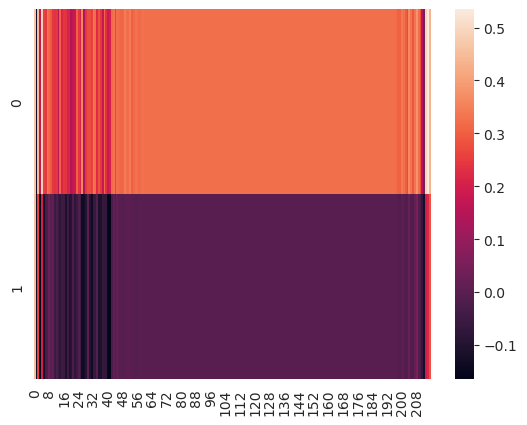

<AxesSubplot: >

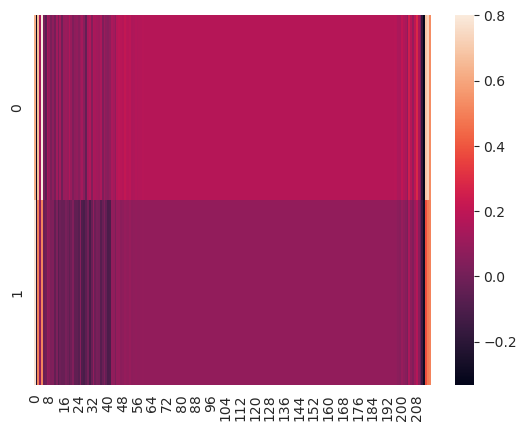

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
model.eval()
sns.heatmap(sim_neg[4][0].squeeze(0).cpu().detach().numpy())
plt.show()
sns.heatmap(sim_pos[4][0].squeeze(0).cpu().detach().numpy())

In [30]:
print(sum([i.numel() for i in model.parameters() if i.requires_grad]))

1163136


In [9]:
model = torch.compile(Model(), fullgraph=True, backend="inductor", mode="reduce-overhead").cuda()
model.load_state_dict(torch.load("mdl", weights_only=True))

<All keys matched successfully>

[21, 9, 6, 1, 21, 9, 10, 15, 8, 1, 10, 20, 1, 10, 14, 1, 2, 24, 2, 26, 1, 21, 9, 10, 20, 1, 24, 6, 6, 12, 6, 15, 5]
tensor([16, 12], dtype=torch.int32)


/tmp/ipykernel_3910/1185887484.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text = model.text(torch.tensor(tk).unsqueeze(0).unsqueeze(1).cuda()).squeeze(0).cpu().detach()


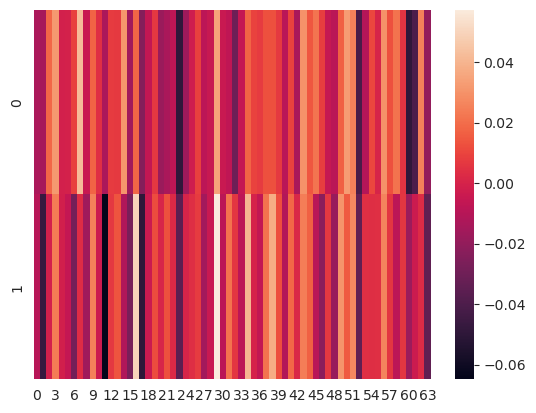

tensor(0.0021)


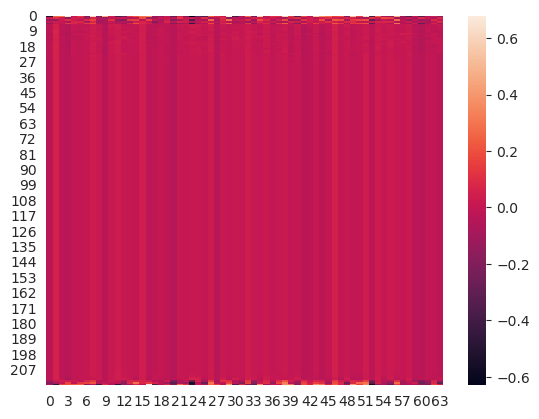

<AxesSubplot: >

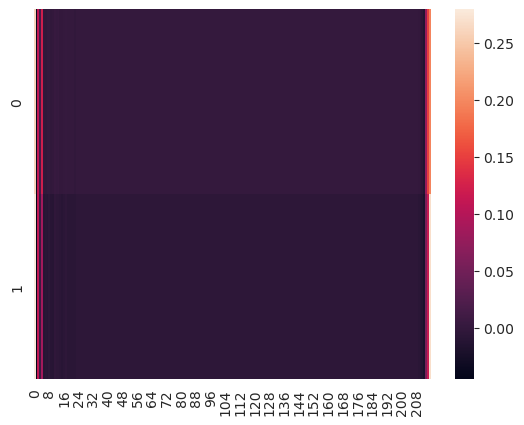

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
print(train[28]["text"])
tk = ds[309][0][0]
print(tk)
text = model.text(torch.tensor(tk).unsqueeze(0).unsqueeze(1).cuda()).squeeze(0).cpu().detach()
sns.heatmap(text)
plt.show()
audio = model.audio(ds[309][2].unsqueeze(0).cuda()).squeeze(0).cpu().detach()
#audio = nn.functional.normalize(audio, dim=-1)
print(audio.mean())
sns.heatmap(audio)
plt.show()
sns.heatmap(torch.matmul(text,  audio.T))

[20, 16, 1, 26, 6, 2, 9, 1, 24, 6, 1, 14, 2, 26, 1, 2, 20, 1, 24, 6, 13, 13, 1, 4, 16, 13, 13, 2, 3, 16, 19, 2, 21, 6]
[20 16]
[ 1 26]
[6 2]
[9 1]
[24  6]
[ 1 14]
[ 2 26]
[1 2]
[20  1]
[24  6]
[13 13]
[1 4]
[16 13]
[13  2]
[ 3 16]
[19  2]
[21  6]


<AxesSubplot: >

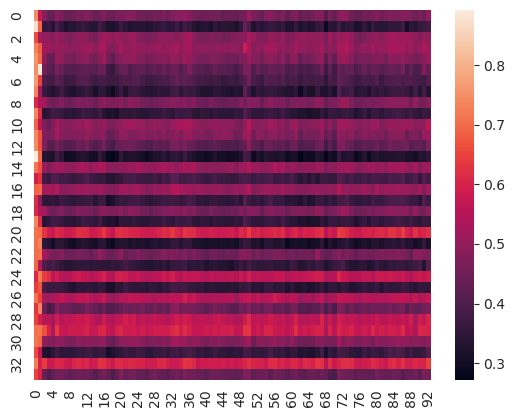

In [45]:
def divide_chunks(l, n):
    for i in range(0, len(l), n): 
        yield l[i:i + n]
model.eval()
print(train[300]["text"])
_, _, audio, mask = ds[300]
matrixes = []
for i in divide_chunks(train[300]["text"], 2):
    tokens = np.asarray(i).astype(int)
    print(tokens)
    with torch.no_grad():
        text = torch.tensor(np.pad(tokens, (0, 2-tokens.shape[0]))).cuda().unsqueeze(0).unsqueeze(0).unsqueeze(0)
        sim = 0.5*(model(audio.unsqueeze(0).cuda(), text[0].cuda(), text[0].cuda())[0]+1).cpu().detach().squeeze(0).squeeze(0)
    matrixes.append(sim)
    
matrixes = torch.cat(matrixes, dim=0)
sns.heatmap(matrixes[:, mask == 1])

In [13]:
torch.save(model.state_dict(), "mdl")